<a href="https://colab.research.google.com/github/yashgandhijee2018/ML-Project/blob/main/Devanagari%20Characters%20Recognition%20Model%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and Importing Dataset


In [1]:
from google.colab import drive  
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
#importing necessary libraries
import os
import keras
import matplotlib
import cv2
import numpy as np
import skimage.io as io
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp

from keras.layers import *
from keras.utils import *
from keras.optimizers import Adam
from keras.models import *

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import model_selection
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from itertools import cycle

In [3]:
# reading data from the disk storage
data= pd.read_csv(r'/content/drive/My Drive/devanagari-character-set.csv')
data.shape

# shape of the data is 92000 images
# and each image is 32x32 with 28 pixels of the region representing the actual text
# and 4 pixels as padding

(92000, 1025)

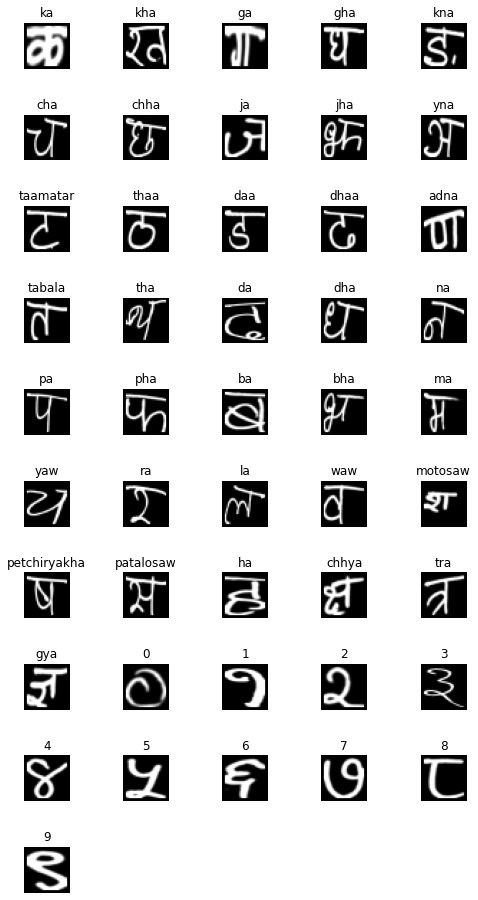

In [4]:
names = data.character.unique()  
rows =10;cols=5;
fig, ax = plt.subplots(rows,cols, figsize=(8,16))

for row in range(rows):
  for col in range(cols):
    ax[row,col].set_axis_off()
    if cols*row+col<len(names):
      x=data[data.character==names[cols*row+col]].iloc[0,:-1].values.reshape(32,32)
      x=x.astype("float64")
      x/=255

      ax[row,col].imshow(x, cmap='gray')
      ax[row,col].set_title(names[cols*row+col].split("_")[-1])

plt.subplots_adjust(wspace=1,hspace=1)
plt.show()

In [5]:
# data=data.sample(n=50000,random_state=6,replace=True)
# data.shape
size=data.shape[0]
print("The size of our dataset is "+str(size))

The size of our dataset is 92000


In [6]:
# for both our training and testing data
#summary of each attribute
print(data.describe())

       pixel_0000  pixel_0001  pixel_0002  ...  pixel_1021  pixel_1022  pixel_1023
count     92000.0     92000.0     92000.0  ...     92000.0     92000.0     92000.0
mean          0.0         0.0         0.0  ...         0.0         0.0         0.0
std           0.0         0.0         0.0  ...         0.0         0.0         0.0
min           0.0         0.0         0.0  ...         0.0         0.0         0.0
25%           0.0         0.0         0.0  ...         0.0         0.0         0.0
50%           0.0         0.0         0.0  ...         0.0         0.0         0.0
75%           0.0         0.0         0.0  ...         0.0         0.0         0.0
max           0.0         0.0         0.0  ...         0.0         0.0         0.0

[8 rows x 1024 columns]


In [7]:
#creating a temp type array of our dataset
array=data.values
#X is for input values and Y is for output given on that input attributes
X=array[:,0:1024].astype(float)
Y=array[:,1024]

## Data Preprocessing

In [8]:
print(Y[0])

character_01_ka


In [9]:
#collecting the digit value from Y[i]
i=0
Y_changed=np.ndarray(Y.shape)
for name in Y:
    x = name.split('_')
    
    if(x[0]=='character'):
        Y_changed[i]=int(x[1])
    elif x[0]=='digit':
        Y_changed[i]=(37 + int(x[1]))
    i=i+1
    
# copy the contents of the array to our original array
Y=Y_changed

#removing the extra elements after memory allocation for numpy array
Y=Y[0:size].copy()
print("The processed Y shape is "+str(Y.shape))

The processed Y shape is (92000,)


## Train and Test Split

In [10]:
#size of the testing data
split_size=0.20
#seed value for keeping same randomness in training and testing dataset
seed=6
#splitting of the data
X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X,Y,test_size=split_size,random_state=seed)

In [11]:
X_test.shape

(18400, 1024)

In [12]:
# reshaping the data in order to convert the given 1D array of an image to actual grid representaion
X_train = X_train.reshape((size*4)//5,32,32,1)
print(X_train.shape)
Y_train = Y_train.reshape((size*4)//5,1)
print(Y_train.shape)
X_test = X_test.reshape(size//5,32,32,1)
print(X_test.shape)
Y_test = Y_test.reshape(size//5,1)
print(Y_test.shape)

(73600, 32, 32, 1)
(73600, 1)
(18400, 32, 32, 1)
(18400, 1)


In [13]:
# a reference array for final classification of data
# reference = {1: 'ka', 2: 'kha', 3: 'ga', 4: 'gha', 5: 'kna', 6: 'cha', 7: 'chha', 8: 'ja', 9: 'jha', 10: 'yna', 11: 'taamatar', 12: 'thaa', 13: 'daa', 14: 'dhaa', 15: 'adna', 16: 'tabala', 17: 'tha', 18: 'da', 19: 'dha', 20: 'na', 21: 'pa', 22: 'pha', 23: 'ba', 24: 'bha', 25: 'ma', 26: 'yaw', 27: 'ra', 28: 'la', 29: 'waw', 30: 'motosaw', 31: 'petchiryakha', 32: 'patalosaw', 33: 'ha', 34: 'chhya', 35: 'tra', 36: 'gya', 37: 0, 38: 1, 39: 2, 40: 3, 41: 4, 42: 5, 43: 6, 44: 7, 45: 8, 46: 9}

reference = {1: 'क', 2: 'ख', 3: 'ग', 4: 'घ', 5: 'ङ', 6: 'च', 7: 'छ', 8: 'ज', 9: 'झ', 10: 'ञ', 11: 'ट', 12: 'ठ', 13: 'ड', 14: 'ढ', 15: 'ण', 16: 'त', 17: 'थ', 18: 'द', 19: 'ध', 20: 'न', 21: 'प', 22: 'फ', 23: 'ब', 24: 'भ', 25: 'म', 26: 'य', 27: 'र', 28: 'ल', 29: 'व', 30: 'स', 31: 'ष', 32: 'श', 33: 'ह', 34: 'श्र', 35: 'त्र', 36: 'ज्ञ', 37: 0, 38: 1, 39: 2, 40: 3, 41: 4, 42: 5, 43: 6, 44: 7, 45: 8, 46: 9}
labels=['क', 'ख', 'ग', 'घ',  'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'स', 'ष', 'श', 'ह', 'श्र', 'त्र', 'ज्ञ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(reference)
print(type(reference))


{1: 'क', 2: 'ख', 3: 'ग', 4: 'घ', 5: 'ङ', 6: 'च', 7: 'छ', 8: 'ज', 9: 'झ', 10: 'ञ', 11: 'ट', 12: 'ठ', 13: 'ड', 14: 'ढ', 15: 'ण', 16: 'त', 17: 'थ', 18: 'द', 19: 'ध', 20: 'न', 21: 'प', 22: 'फ', 23: 'ब', 24: 'भ', 25: 'म', 26: 'य', 27: 'र', 28: 'ल', 29: 'व', 30: 'स', 31: 'ष', 32: 'श', 33: 'ह', 34: 'श्र', 35: 'त्र', 36: 'ज्ञ', 37: 0, 38: 1, 39: 2, 40: 3, 41: 4, 42: 5, 43: 6, 44: 7, 45: 8, 46: 9}
<class 'dict'>


In [14]:
#normalization of data
X_train = X_train/255
X_test = X_test/255

In [15]:
X_train, Y_train = shuffle(X_train, Y_train, random_state = 2)
X_test, Y_test = shuffle(X_test, Y_test, random_state = 2)

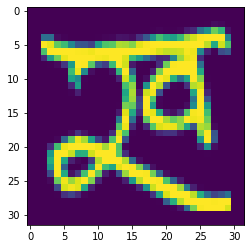

ख


In [16]:
plt.imshow(np.squeeze(X_test[256]))
plt.show()
print(reference.get(int(Y_test[256])))

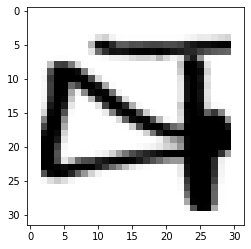

ष


In [17]:
#greyscale image
plt.imshow(np.squeeze(X_test[67]),cmap=matplotlib.cm.binary,interpolation="nearest")
plt.show()
print(reference.get(int(Y_test[67])))

In [18]:
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.6, random_state = 1)
print(X_test.shape)
print(X_val.shape)

(7360, 32, 32, 1)
(11040, 32, 32, 1)


In [19]:
Y_test = to_categorical(Y_test)
print(Y_test.shape)

(7360, 47)


In [20]:
Y_val = to_categorical(Y_val)
print(Y_val.shape)

(11040, 47)


In [21]:
Y_train = to_categorical(Y_train)
print(Y_train.shape)

(73600, 47)


## Working of different Layers:


*   Convolutional 2D layer
*   Maxpooling 2D Layer



>> Convolutional 2D Layer


(32, 32)

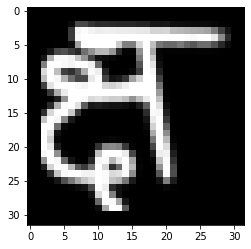

In [22]:
#reading the sample image from the drive
img=cv2.imread('/content/drive/My Drive/ML Data/21081.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap='gray')
img.shape

In [23]:
#keras expects batches of images, adding dimensions in order to trick it into a batch
img_batch=img.reshape(1,img.shape[0],img.shape[1],1)
img_batch.shape

(1, 32, 32, 1)

In [24]:
model1=Sequential()
channels=64
model1.add(Conv2D(64,3,padding='same',activation='relu',input_shape=img_batch.shape[1:]))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        640       
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


In [25]:
#predicting from the batch and generating the 64 channels of the convolution layer:
conv_img=model1.predict(img_batch)

#reshaping the given numpy array so as to plot every image using pyplot 
conv_img.shape
conv_img=conv_img.reshape(channels,32,32)

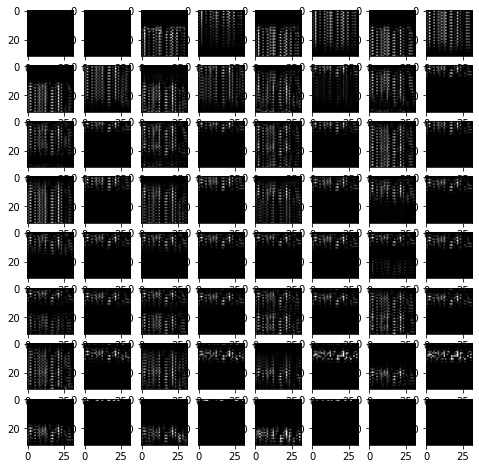

In [26]:
plt.figure(figsize=(8,8)) # specifying the overall grid size

for i in range(64):
    plt.subplot(8,8,i+1)    # the number of images in the grid is 8*8 (64)
    plt.imshow(conv_img[i],cmap='gray')

plt.show()

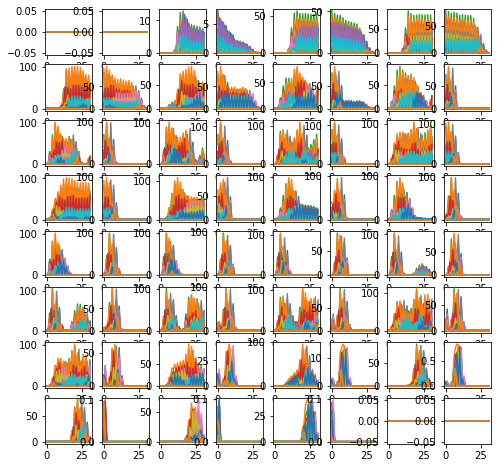

In [27]:
plt.figure(figsize=(8,8)) # specifying the overall grid size

for i in range(64):
    plt.subplot(8,8,i+1)    # the number of images in the grid is 8*8 (64)
    plt.plot(conv_img[i])

plt.show()

>> Maxpooling 2D

In [28]:
model2=Sequential()
channels=64
model2.add(Conv2D(64,3,padding='same',activation='relu',input_shape=img_batch.shape[1:]))
model2.add(MaxPooling2D((2,2)))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
Total params: 640
Trainable params: 640
Non-trainable params: 0
_________________________________________________________________


In [29]:
#predicting from the batch and generating the 64 channels of the convolution layer:
conv_img=model2.predict(img_batch)

#reshaping the given numpy array so as to plot every image using pyplot 
conv_img.shape
conv_img=conv_img.reshape(channels,16,16)

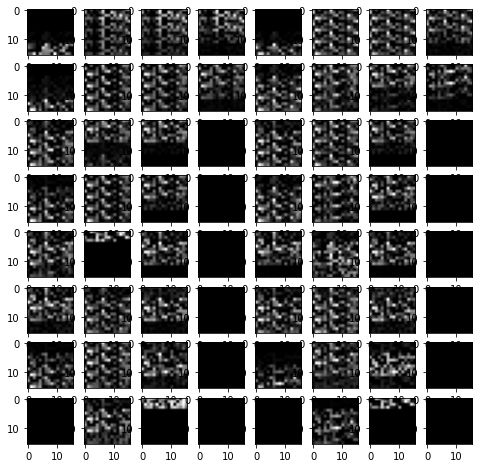

In [30]:
plt.figure(figsize=(8,8)) # specifying the overall grid size

for i in range(64):
    plt.subplot(8,8,i+1)    # the number of images in the grid is 8*8 (64)
    plt.imshow(conv_img[i],cmap='gray')

plt.show()

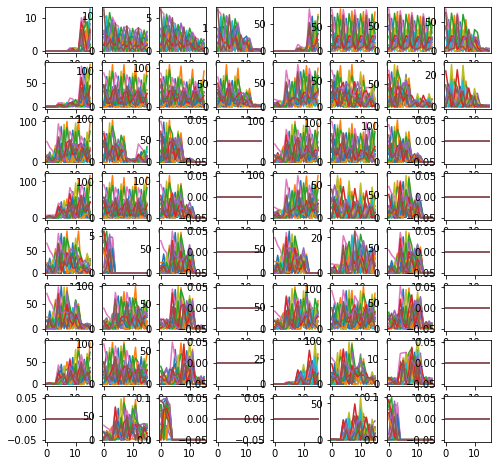

In [31]:
plt.figure(figsize=(8,8)) # specifying the overall grid size

for i in range(64):
    plt.subplot(8,8,i+1)    # the number of images in the grid is 8*8 (64)
    plt.plot(conv_img[i])

plt.show()

## CNN Model Training

In [32]:
inputs = Input(shape = (32,32,1))
conv1 = Conv2D(64, 3, padding='same', activation='relu')(inputs)
conv2 = Conv2D(128, 3, padding='same', activation='relu')(conv1)
pool2 = MaxPooling2D((2,2))(conv2)
conv3 = Conv2D(128, 3, padding='same', activation='relu')(pool2)
conv4 = Conv2D(256, 5, padding='same', activation='relu')(conv3)
pool4 = MaxPooling2D((2,2))(conv4)
conv5 = Conv2D(256, 5, padding='same', activation='relu')(pool4)
flat = Flatten()(conv5)
dense0 = Dense(512, activation='relu')(flat)
dense1 = Dense(128, activation='relu')(dense0)
dense2 = Dense(47, activation='softmax')(dense1)

model = Model(inputs, dense2)
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)        

In [33]:
model.compile(Adam(lr = 10e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 400, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
184/184 [==============================] - 22s 121ms/step - loss: 0.9540 - accuracy: 0.7396 - val_loss: 0.1558 - val_accuracy: 0.9543
Epoch 2/20
184/184 [==============================] - 22s 120ms/step - loss: 0.0979 - accuracy: 0.9705 - val_loss: 0.0882 - val_accuracy: 0.9760
Epoch 3/20
184/184 [==============================] - 23s 123ms/step - loss: 0.0446 - accuracy: 0.9859 - val_loss: 0.0626 - val_accuracy: 0.9805
Epoch 4/20
184/184 [==============================] - 23s 126ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.0937 - val_accuracy: 0.9746
Epoch 5/20
184/184 [==============================] - 23s 127ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0870 - val_accuracy: 0.9778
Epoch 6/20
184/184 [==============================] - 23s 126ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0646 - val_accuracy: 0.9845
Epoch 7/20
184/184 [==============================] - 23s 125ms/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.0635 - val_ac

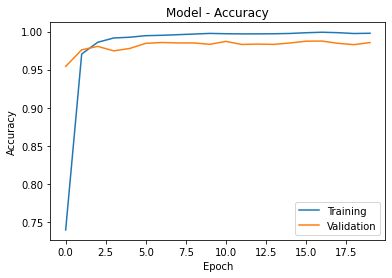

In [34]:
# Accuracy
print(history)
fig1, ax_acc = plt.subplots()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model - Accuracy')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

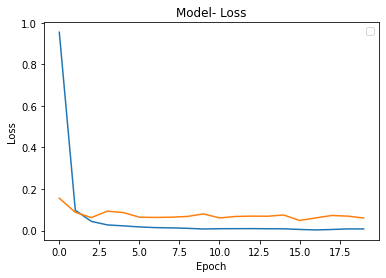

In [35]:
# Loss
fig2, ax_loss = plt.subplots()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model- Loss')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [36]:
model.save("/content/drive/My Drive/Model_1.h5")

# Model Testing and Accuracy check


*   model.evaluate()
*   AUC and ROC
*   Accuracy Score
*   Precision, Recall, F1-score, Support
*   Confusion Matrix




In [37]:
model.evaluate(X_test, Y_test, batch_size = 400, verbose =1)

19/19 [==============================] - 1s 49ms/step - loss: 0.0675 - accuracy: 0.9842


[0.0674709677696228, 0.9842391014099121]

In [38]:
Y_pred = model.predict(x = X_test, verbose = 1)
Y_score=model.predict(X_test)
print(Y_score)

230/230 [==============================] - 1s 5ms/step
[[2.0858098e-14 7.1222698e-14 3.1735853e-13 ... 6.9005079e-10
  8.2707485e-09 3.3444709e-09]
 [8.3330288e-24 5.1635721e-14 6.3660451e-08 ... 4.6530353e-18
  2.6386017e-15 1.7432432e-16]
 [9.0336809e-13 8.7584331e-09 1.9371625e-07 ... 2.1929417e-07
  2.9258123e-05 1.0760392e-07]
 ...
 [9.0888511e-26 2.8531708e-12 1.3636814e-12 ... 1.0908240e-22
  6.0561050e-16 1.2901355e-19]
 [1.2637164e-11 3.0196553e-08 4.9224099e-07 ... 4.0718755e-13
  3.1149058e-10 1.3133957e-11]
 [1.7439415e-24 1.0969665e-22 1.6247940e-17 ... 1.0000000e+00
  6.9215585e-11 5.1524925e-15]]


In [39]:
n_classes=47
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [40]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  del sys.path[0]


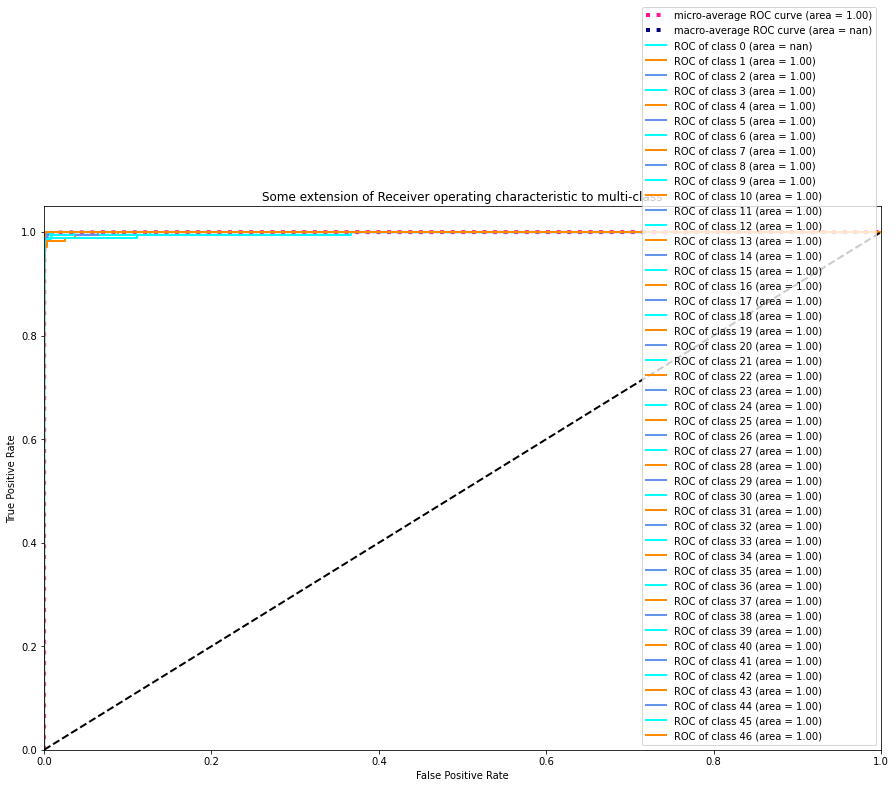

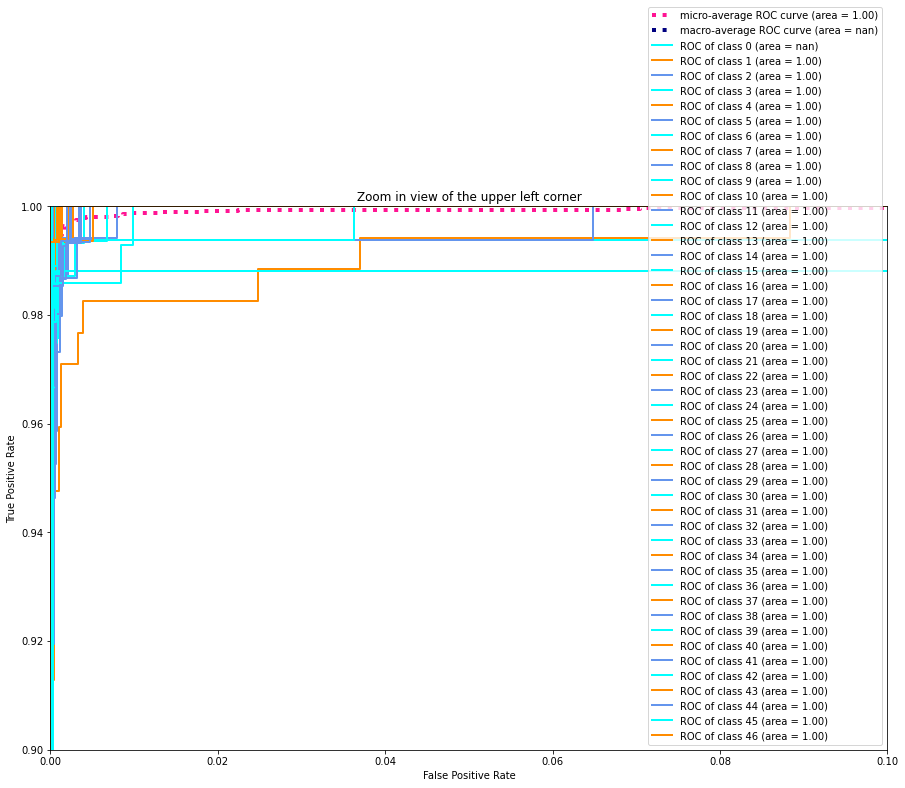

In [41]:
# Plot all ROC curves
lw=2
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
figure = plt.gcf()  # get current figure
figure.set_size_inches(15,10)
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.1)
plt.ylim(0.9, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Zoom in view of the upper left corner')
plt.legend(loc="lower right")
figure = plt.gcf()  # get current figure
figure.set_size_inches(15,10)
plt.show()

In [42]:
Y_pred = np.argmax(Y_pred, axis = 1)
print(Y_pred.shape)
Y_test = np.argmax(Y_test, axis = 1)
print(Y_test.shape)

(7360,)
(7360,)


ड


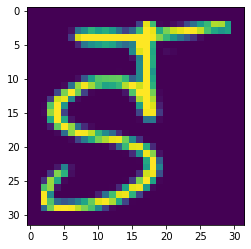

In [43]:
index = 54
img = X_test[index]
img = img.reshape((32,32))
plt.imshow(img)
print(reference[Y_pred[index]])

In [44]:
print("Classification report for the model %s:\n%s\n" % (model, metrics.classification_report(Y_test, Y_pred)))

Classification report for the model <tensorflow.python.keras.engine.functional.Functional object at 0x7f27c24fc3c8>:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       161
           2       0.99      0.99      0.99       167
           3       1.00      0.99      0.99       146
           4       0.98      0.94      0.96       172
           5       0.99      0.97      0.98       151
           6       0.99      0.98      0.99       162
           7       0.98      0.99      0.99       162
           8       0.99      0.99      0.99       184
           9       0.99      1.00      1.00       173
          10       0.98      0.99      0.99       168
          11       1.00      0.97      0.98       159
          12       1.00      0.99      1.00       151
          13       0.97      0.99      0.98       146
          14       0.98      0.95      0.96       154
          15       0.99      0.99      0.99       150
          16      

In [45]:
#For plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, labels=target_names, rotation=45)
        plt.yticks(tick_marks, labels=target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True values')
    plt.xlabel('Predicted values\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    figure = plt.gcf()  # get current figure
    figure.set_size_inches(25,25)
    plt.show()

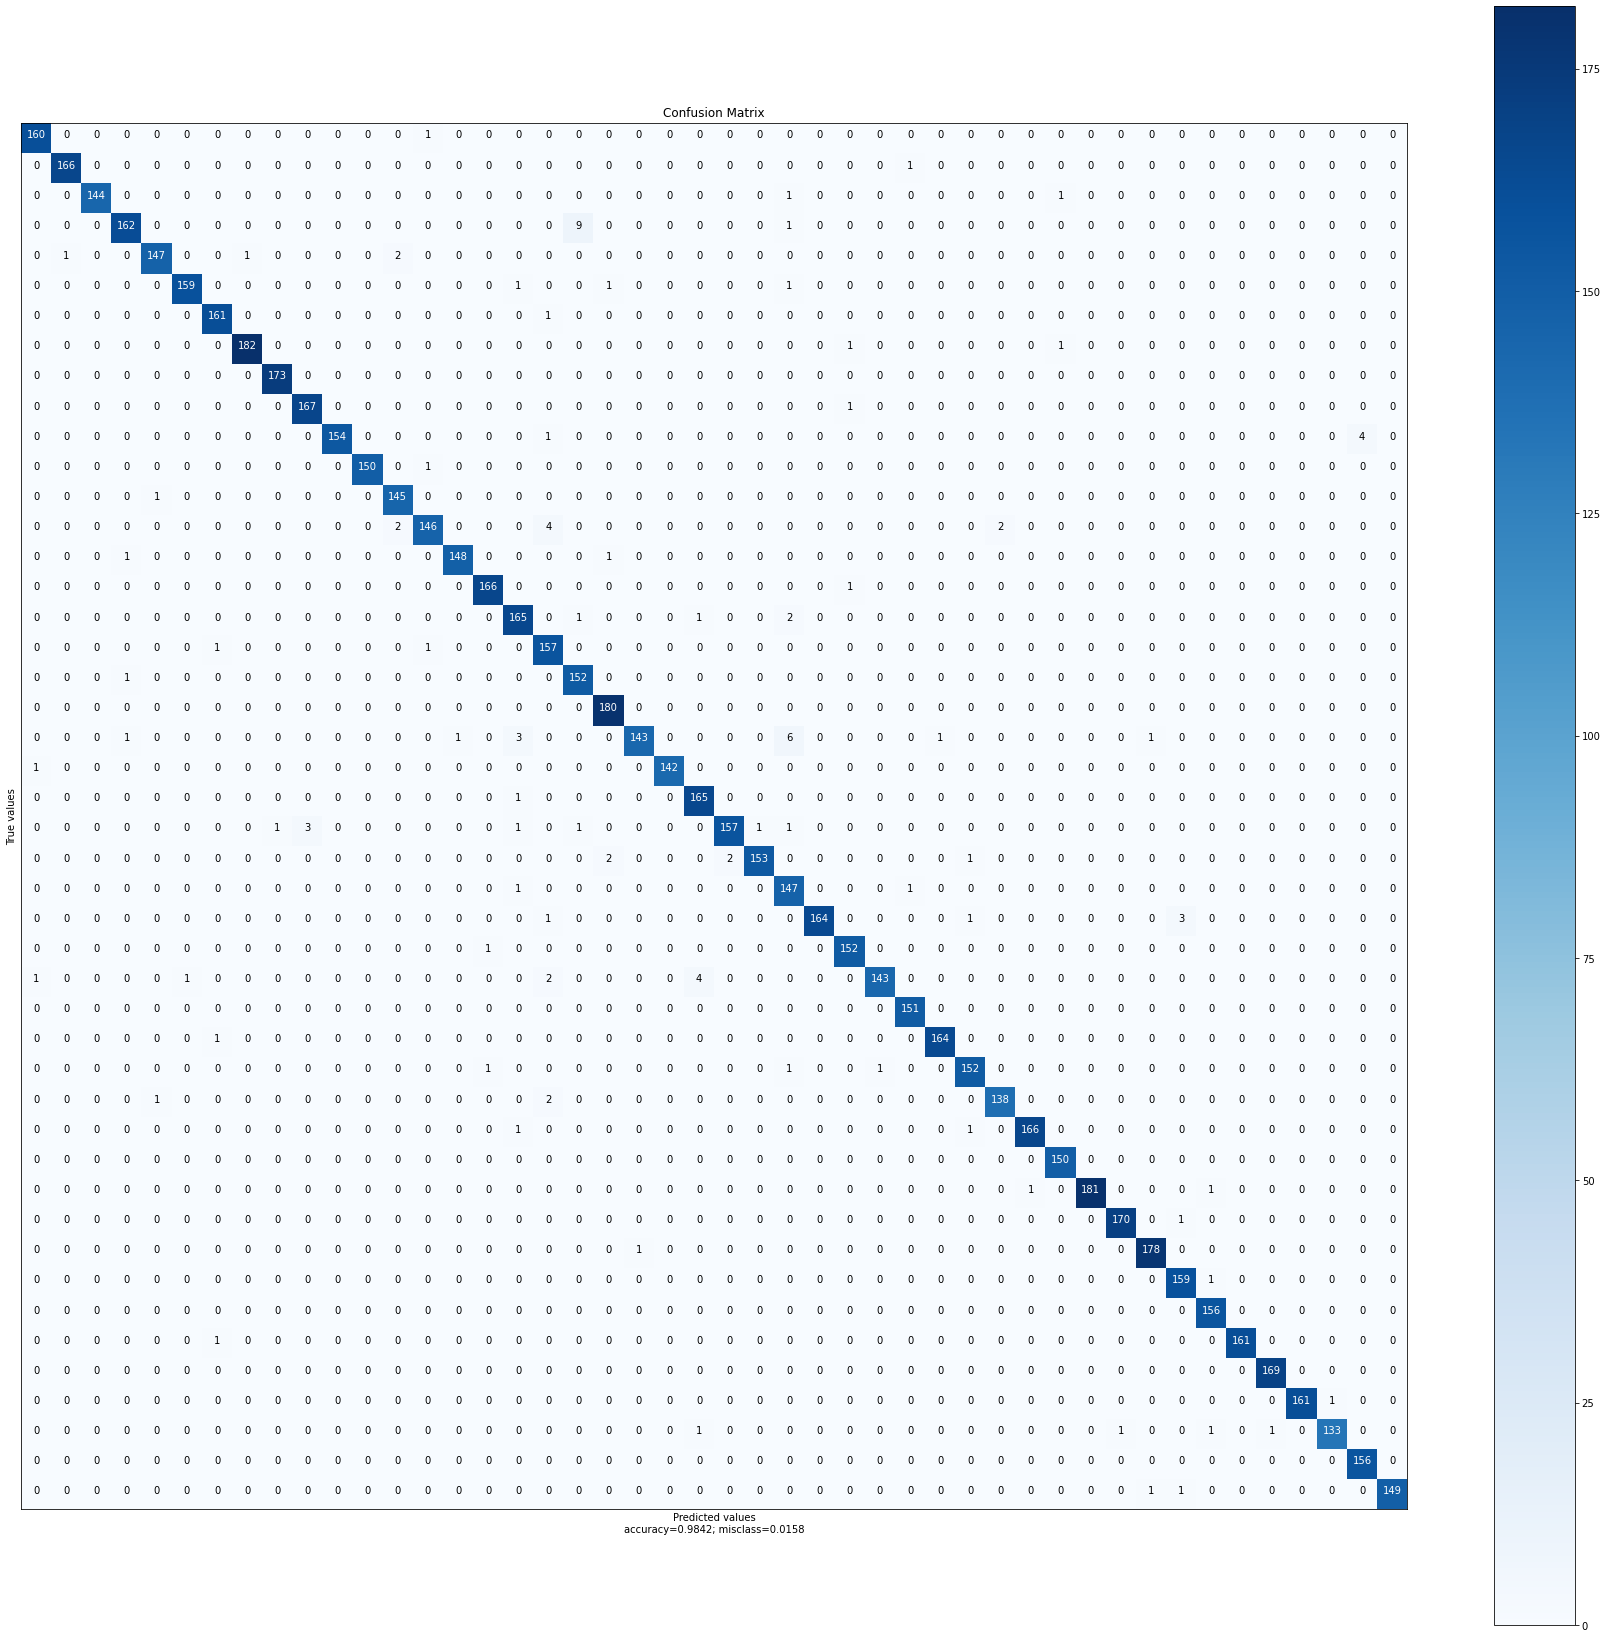

In [46]:
import seaborn as sns
cm = metrics.confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm=cm, normalize=False, target_names='', title="Confusion Matrix")

In [47]:
# #Calculating values

# FP = cm.sum(axis=0) - np.diag(cm)  
# FN = cm.sum(axis=1) - np.diag(cm)
# TP = np.diag(cm)
# TN = cm.sum() - (FP + FN + TP)

# FP = FP.astype(float)
# FN = FN.astype(float)
# TP = TP.astype(float)
# TN = TN.astype(float)

# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)
# # Overall accuracy